In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import h5py
import scipy.interpolate
from matplotlib.pyplot import figure
import glob

from asispectralinversion.inversion import *
from asispectralinversion.preprocessing import *
#from asi_inv import *
from apexpy import Apex

# Copies an HDF5 structure to a python dict recursively
def copy_h5(vtest):
    # Initialize dict to output
    dicttest = {}
    # List of keys in dataset
    keyslist = list(vtest.keys())
    # Iterate through keys
    for key in keyslist:
        # vtest[key] is an array
        if type(vtest[key]) == h5py._hl.dataset.Dataset:
            # vtest[key] is a 0d or 1d array
            if vtest[key].shape[1] == 1:
                # vtest[key] is a 0d array
                if vtest[key].shape[0] == 1:
                    # extract the float value of vtest[key]
                    dicttest[key] = vtest[key][0][0]
                # vtest[key] is a 1d array
                else:
                    # extract the numpy array
                    dicttest[key] = np.asarray(vtest[key]).flatten()
            # vtest[key] is a 2 or more dimensional array
            else:
                # extract the numpy array
                dicttest[key] = np.asarray(vtest[key])
        # vtest[key] is another hdf5 structure
        else:
            # Recursively apply copy_h5 to the sub-structure
            dicttest[key] = copy_h5(vtest[key])
    return dicttest

# THINGS TO ADD:

## - Add second order inversion

# Choose a date

In [2]:
# Right now we have March 14 and 19 for examples
date = '20230314'
#date = '20230319'
dtdate = datetime.date(int(date[:4]),int(date[4:6]),int(date[6:]))

## Other parameters

In [3]:
maglatsite = 65.8
# Gaussian blur width in degrees maglon
blur_deg_EW = 0.4
# Gaussian blur width in degrees maglat (should be smaller!)
blur_deg_NS = 0.04

# n_shifts, integer determining shift-invariance of wavelets (higher is better, but slower and has diminishing returns)
n_shifts = 30


# Do we use dark patches in the sky to set background brightness, or just use the corners?
background_method = 'patches'
#background_method = 'corners'

## Let's start with a quick self-test: after reading in our inversion tables, we sample RGB brightnesses and see how well we can invert back to what we started with

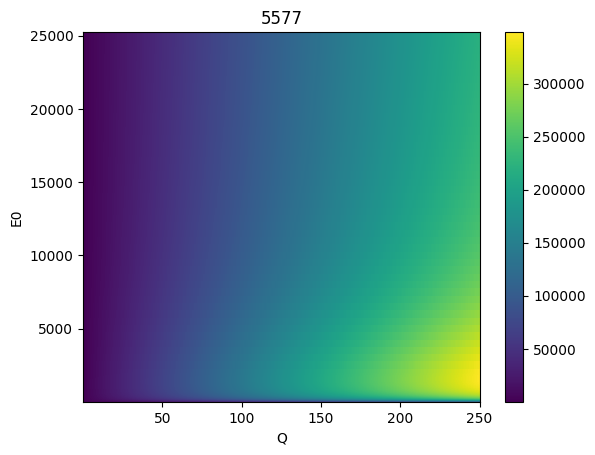

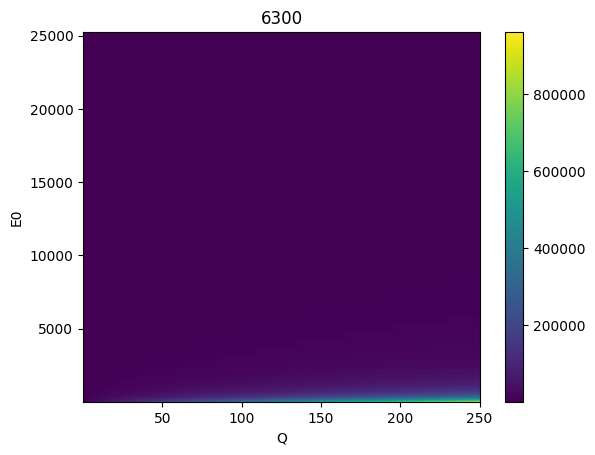

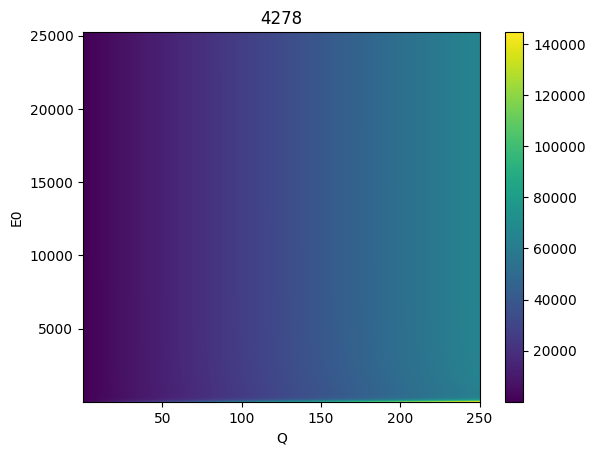

In [4]:
folder = 'test_data_'+date+'/'

fnamered = glob.glob(folder+'I6300*.bin')[0]
fnamegreen = glob.glob(folder+'I5577*.bin')[0]
fnameblue = glob.glob(folder+'I4278*.bin')[0]
fnameped = glob.glob(folder+'ped3d*.bin')[0]
fnamehall = glob.glob(folder+'hall3d*.bin')[0]

v = load_lookup_tables(fnamered, fnamegreen, fnameblue, fnameped, fnamehall, maglatsite, plot=True)

In [ ]:
# A bunch of E0s to sample
trueE0vec = np.amax(v['E0vec'])*0.95*(np.sin(v['Qvec']/0.5))**2 + 100
# The closest indices for each E0
trueE0indvec = np.asarray([np.argmin(np.abs(v['E0vec']-trueE0vec[i])) for i in range(len(trueE0vec))])
# We use every q index
qindvec = np.arange(len(v['Qvec']))

# Every Q value
Qvectest = v['Qvec'][qindvec]
# The nearest "snapped" E0 values to the ones we chose
E0vectest = v['E0vec'][trueE0indvec]
e0order = np.argsort(E0vectest)

################ PLOTTING ################
plt.pcolormesh(v['Qvec'],v['E0vec'],np.log(v['redmat']/v['greenmat']))
#plt.scatter(v['Qvec'],trueE0vec,color='pink')
plt.scatter(Qvectest,E0vectest,color='red')
plt.xlabel('Q')
plt.ylabel('E0')
plt.title('sampling the whole space!')
plt.show()
################          ################
# Pulling out RGB values
greentrace = np.asarray([v['greenmat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])
redtrace = np.asarray([v['redmat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])
bluetrace = np.asarray([v['bluemat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])

logredtrace = np.log(redtrace)
logratiotrace = np.log(redtrace/greentrace)

################ PLOTTING ################
# plt.scatter(trueE0vec[np.argsort(trueE0vec)],bluetrace[np.argsort(trueE0vec)],color='blue',s=5)
# #plt.scatter(trueE0vec[np.argsort(trueE0vec)][np.where(bluetrace[np.argsort(trueE0vec)]>maxbluebright)],bluetrace[np.argsort(trueE0vec)][np.where(bluetrace[np.argsort(trueE0vec)]>maxbluebright)],color='red',s=5)

# plt.title('Red points have too high of a blue brightness')
# plt.xlabel('E0')
# plt.ylabel('Blue Brightness')
# plt.show()
################          ################
# Inferring Q
#qoutvec,maxqvec,minqvec =  q_interp(v['bluemat'],v['Qvec'],v['E0vec'],bluetrace,minE0ind=59,maxbluebright='auto',interp='linear',plot=False)
qoutvec,e0outvec,minqvec,maxqvec,mine0vec,maxe0vec = calculate_E0_Q(redtrace,greentrace,bluetrace,v,minE0=150,generous=True)


################ PLOTTING ################
# How did we do?
plt.scatter(np.arange(len(qoutvec)),maxqvec,color='red',label='inferred max q')
plt.scatter(np.arange(len(qoutvec)),minqvec,color='blue',label='inferred min q')
plt.plot(np.arange(len(qoutvec)),Qvectest,color='green',label='real q')
plt.title('How did we do? Q inversion')
plt.legend()
plt.ylabel('Q')
plt.show()

plt.title('How did we do? Q inversion')
plt.scatter(np.arange(len(qoutvec)),Qvectest,color='green',label='real q')
plt.scatter(np.arange(len(qoutvec)),qoutvec,color='purple',label='best guess',s=5)
plt.scatter(np.arange(len(qoutvec))[np.where(np.isnan(maxqvec+minqvec))],qoutvec[np.where(np.isnan(maxqvec+minqvec))],color='red',label='no valid bounds',s=5)

plt.legend()
plt.ylabel('Q')
plt.show()
################          ################

# Inferring E0
#e0outvec = e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),qoutvec)
#e0ext1,e0ext2 = e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),maxqvec),e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),minqvec)

In [ ]:
plt.scatter(np.arange(len(qoutvec)),maxe0vec[e0order],color='red',label='inferred max E0')
plt.scatter(np.arange(len(qoutvec)),mine0vec[e0order],color='blue',label='inferred min E0')
plt.scatter(np.arange(len(qoutvec)),E0vectest[e0order],color='green',s=5,label='real E0')
plt.legend()
plt.ylabel('E0')
plt.title('How did we do? E0 inversion')
plt.show()

plt.scatter(np.arange(len(qoutvec)),E0vectest[e0order],color='green',label='real E0',s=100)
plt.scatter(np.arange(len(qoutvec)),e0outvec[e0order],color='purple',s=20,label='best guess')
plt.title('How did we do? E0 inversion')
plt.legend()
plt.ylabel('E0')

In [ ]:
print('median absolute Q % error')
medqerror = np.median((100*np.abs((qoutvec-Qvectest))/Qvectest)[np.where(~np.isnan(np.abs((qoutvec-Qvectest))/Qvectest))])
print(str(np.round(medqerror,3))+'%')

print('median absolute E0 % error')
mede0error = np.median((100*np.abs((e0outvec-E0vectest))/E0vectest)[np.where(~np.isnan(np.abs((e0outvec-E0vectest))/E0vectest))])
print(str(np.round(mede0error,3))+'%')

# Now let's try inverting real imagery data

In [ ]:
redims = copy_h5(h5py.File(folder+'reddata.mat'))
greenims = copy_h5(h5py.File(folder+'greendata.mat'))
blueims = copy_h5(h5py.File(folder+'bluedata.mat'))

vskymap = copy_h5(h5py.File(folder+'skymap.mat')['magnetic_footpointing'])
skymapred = [vskymap['180km']['lat'],vskymap['180km']['lon']]
skymapgreen = [vskymap['110km']['lat'],vskymap['110km']['lon']]
skymapblue = [vskymap['107km']['lat'],vskymap['107km']['lon']]


In [ ]:
plt.imshow(redims['frame2'])
plt.title('red imagery')
plt.show()
plt.imshow(greenims['frame2'])
plt.title('green imagery')
plt.show()
plt.imshow(blueims['frame2'])
plt.title('blue imagery')
plt.show()

## We start by stacking the 3 frames for each color to suppress noise slightly

In [ ]:
greenimcoadd = (greenims['frame1']+greenims['frame2']+greenims['frame3'])/3
blueimcoadd = (blueims['frame1']+blueims['frame2']+blueims['frame3'])/3
redimcoadd = (redims['frame1']+redims['frame2']+redims['frame3'])/3

In [ ]:
# # Or we only stack blue...

# greenimcoadd = greenims['frame2']
# blueimcoadd = (blueims['frame1']+blueims['frame2']+blueims['frame3'])/3
# redimcoadd = redims['frame2']

In [ ]:
plt.imshow(redimcoadd)
plt.title('red imagery')
plt.show()
plt.imshow(greenimcoadd)
plt.title('green imagery')
plt.show()
plt.imshow(blueimcoadd)
plt.title('blue imagery')
plt.show()

## We initialize Apex - we are going to remap these 3 images onto the same new grid

In [ ]:
A = Apex(date=dtdate)
bmla, bmlo = A.convert(skymapblue[0].reshape(-1), np.mod(skymapblue[1].reshape(-1),360), 'geo', 'apex', height=110)

minmlat = np.amin(bmla[np.where(~np.isnan(bmla))])
maxmlat = np.amax(bmla[np.where(~np.isnan(bmla))])

minmlon = np.amin(bmlo[np.where(~np.isnan(bmlo))])
maxmlon = np.amax(bmlo[np.where(~np.isnan(bmlo))])

interplonvec = np.linspace(minmlon,maxmlon,1024)
interplatvec = np.linspace(minmlat,maxmlat,1024)

## We remap the images onto our new grid, while also denoising and estimating background brightness and initial noise level

### In this example, we use a Bayesian wavelet based denoising algorithm to blur the image as little as possible
nshifts is a parameter controlling the shift-invariance of the wavelets, and should probably be set between 5 and 70, or so... 
Here we set nshifts=30 to speed up computation, but its default value is 50 (I probably set it higher than necessary)

In [ ]:
blueimdenoisewavelet,blueimreg,lon110,lat110,maglon,maglat,bluebgbright,bluesig = wavelet_denoise_resample(blueimcoadd,dtdate,skymapblue[1],skymapblue[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)

## Try again with gaussian blurring - note that there is intentionally significantly more blurring in the E-W than N-S direction

In [ ]:
blueimdenoisegauss,_,_,_,_,_,_,_ = gaussian_denoise_resample(blueimcoadd,dtdate,skymapblue[1],skymapblue[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)

## Let's compare the residual from denoising to a simulated noise field from our background fitting

In [ ]:
noise = np.copy(skymapblue[0]).reshape(-1)
noiseadd = (np.random.randn(len(noise[np.where(~np.isnan(noise))]))*bluesig)
noise[np.where(~np.isnan(noise))] = noiseadd
noise = noise.reshape(skymapblue[0].shape)

In [ ]:
plt.pcolormesh(lon110,lat110,blueimreg-blueimdenoisewavelet,vmin=-4*bluesig,vmax=4*bluesig)
plt.title('residual map for wavelet denoising')
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()
plt.show()
plt.pcolormesh(lon110,lat110,blueimreg-blueimdenoisegauss,vmin=-4*bluesig,vmax=4*bluesig)
plt.title('residual map for gaussian denoising')
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()
plt.show()
plt.title('simulated noise field')
plt.pcolor(skymapgreen[1],skymapgreen[0],noise,vmin=-4*bluesig,vmax=4*bluesig)
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()


## We use wavelet denoising on the red and green channels, or uncomment the gaussian denoising instead

In [ ]:
redimdenoise,redimreg,_,_,_,_,redbgbright,redsig = wavelet_denoise_resample(redimcoadd,dtdate,skymapred[1],skymapred[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)
greenimdenoise,greenimreg,_,_,_,_,greenbgbright,greensig = wavelet_denoise_resample(greenimcoadd,dtdate,skymapgreen[1],skymapgreen[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)
blueimdenoise = np.copy(blueimdenoisewavelet)
# redimdenoise,redimreg,_,_,_,_,redbgbright,redsig = gaussian_denoise_resample(redimcoadd,dtdate,skymapred[1],skymapred[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)
# greenimdenoise,greenimreg,_,_,_,_,greenbgbright,greensig = gaussian_denoise_resample(greenimcoadd,dtdate,skymapgreen[1],skymapgreen[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)
# blueimdenoise = np.copy(blueimdenoisegauss)

In [ ]:
# This is just a visualization tool - I tried to strike a balance between brightening the dim colors and allowing them to overwhelm the image

ngreen = (1/np.std(greenimreg[np.where(~np.isnan(greenimreg))]))**(6.5/8)
nred = (1/np.std(redimreg[np.where(~np.isnan(redimreg))]))**(6.5/8)
nblue = (1/np.std(blueimreg[np.where(~np.isnan(blueimreg))]))**(6.5/8)

greenframe = np.copy(greenimreg)
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimreg)
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimreg)
redframe[np.where(np.isnan(redframe))] = redbgbright


greenmin = np.amin(greenframe)
bluemin = np.amin(blueframe)
redmin = np.amin(redframe)

# ngreen=100/np.median(greenframe-greenmin)
# nred = 100/np.median(redframe-redmin)
# nblue=100/np.median(blueframe-bluemin)


#colormat = np.asarray([3*(redframe-redmin),(greenframe-greenmin),10*(blueframe-bluemin)]).astype(float)
colormat = np.asarray([nred*(redframe-redmin),ngreen*(greenframe-greenmin),nblue*(blueframe-bluemin)]).astype(float)

maxbright = np.amax(colormat)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon.T,maglat.T,greenframe,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, original, magnetic coords')

In [ ]:
greenframe = np.copy(greenimdenoise)
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimdenoise)
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimdenoise)
redframe[np.where(np.isnan(redframe))] = redbgbright

colormat = np.asarray([nred*(redframe-redmin),ngreen*(greenframe-greenmin),nblue*(blueframe-bluemin)]).astype(float)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon.T,maglat.T,greenframe,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, denoised, magnetic coords')

# Now we have the preprocessed image, let's convert it to Rayleighs according to the *approximate* nominal calibrations

### Use the radioactive source calibrations to *roughly* convert counts -> rayleighs

In [ ]:
redray,greenray,blueray = to_rayleighs(redimdenoise,greenimdenoise,blueimdenoise,redbgbright,greenbgbright,bluebgbright)

## Let's set every pixel that does not have a valid RGB coordinate to NaN

In [ ]:
badrange = np.where(np.isnan(redray+blueray+greenray))
redray[badrange] = np.nan
greenray[badrange] = np.nan
blueray[badrange] = np.nan

In [ ]:
negatives = np.zeros_like(blueray)
negatives[np.where( (redray<0) | (blueray<0) | (greenray<0) )] = 1
negatives[np.where(np.isnan(blueray))] = np.nan

In [ ]:
plt.pcolormesh(lon110,lat110,negatives)
plt.title('Yellow is regions where any brightnesses are negative')

### Unfortunately we almost certainly have a few pixels that have negative brightnesses - we just set these to zeros, or one could set them to NaNs

In [ ]:
redray[np.where(redray<0)]=0
greenray[np.where(greenray<0)]=0
blueray[np.where(blueray<0)]=0

## Finally, let's decimate for time efficiency

In [ ]:
dec = 10
# Note: dec=2 returns the original resolution, no need to do dec=1

In [ ]:
redraydec = redray[::dec,::dec]
blueraydec = blueray[::dec,::dec]
greenraydec = greenray[::dec,::dec]

In [ ]:
greenframe = np.copy(greenimdenoise)[::dec,::dec]
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimdenoise)[::dec,::dec]
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimdenoise)[::dec,::dec]
redframe[np.where(np.isnan(redframe))] = redbgbright

colormat = np.asarray([nred*(redframe-redmin),ngreen*(greenframe-greenmin),nblue*(blueframe-bluemin)]).astype(float)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon[::dec,::dec].T,maglat[::dec,::dec].T,greenframe,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, decimated, magnetic coords')

# Invert to Q,E0:

In [ ]:
qout,e0out,minq,maxq,mine0,maxe0 = calculate_E0_Q(redraydec,greenraydec,blueraydec,v,minE0=150,generous=True)

In [ ]:
plt.title('Map of Q')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],qout)
plt.colorbar()
plt.show()
plt.title('Map of E0')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],e0out,cmap='magma')
plt.colorbar()
plt.show()

# Calculate SigP, SigH

## Note: Don says E-region densities for 3/19 are unphysically high, leading to extremely high conductances. Do not trust them!

In [ ]:
SigP,SigH = calculate_Sig(qout,e0out,v,generous=True)

In [ ]:
plt.title('Map of SigP')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigP)
plt.colorbar()
plt.show()
plt.title('Map of SigH')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigH)
plt.colorbar()
plt.show()

In [ ]:
plt.title('Map of SigH/SigP')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigH/SigP)
plt.colorbar()
plt.show()